In [13]:
# Import dependencies

import numpy as np

import torch
import random

%load_ext autoreload
%autoreload 2

SEED = 42
torch.manual_seed(42)  # Fixes the seed for PyTorch
np.random.seed(42)  # Fixes the seed for NumPy
random.seed(42)  # Fixes the seed for Python's random module

SLIDING_WINDOW_SIZE = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Load data
import helpers
import os
import pandas as pd

action_folders = [
    "badminton",
    "boxing",
    "fencing",
    "golf",
    "logout",
    "reload",
    "shield",
    "snowbomb",
]
tuples = []
test_tuples = []

for idx, folder in enumerate(action_folders):
    data_path = os.path.join("dataset", folder)
    for csv_file in os.listdir(data_path):
        dataframe = pd.read_csv(os.path.join(data_path, csv_file))
        if csv_file == "test.csv":
            test_tuples.append((dataframe, idx))
        else:
            tuples.append((dataframe, idx))

x, y = helpers.generate_data(tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE, stride=SLIDING_WINDOW_SIZE)
# x_test, y_test = helpers.generate_data(test_tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE, stride = SLIDING_WINDOW_SIZE)


print("Shape of feature vector is " + str(x.shape))
print("Shape of output vector is " + str(y.shape))

Shape of feature vector is (1479, 10, 6)
Shape of output vector is (1479,)


In [15]:
# Split data
from sklearn.model_selection import train_test_split

# raw_x_train, raw_x_test, y_train, y_test = x, x_test, y, y_test

raw_x_train, raw_x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

print("Shape of raw_x_train is " + str(raw_x_train.shape))
print("Shape of y_train is " + str(y_train.shape))
print("Shape of raw_x_test is " + str(raw_x_test.shape))
print("Shape of y_test is " + str(y_test.shape))

Shape of raw_x_train is (1183, 10, 6)
Shape of y_train is (1183,)
Shape of raw_x_test is (296, 10, 6)
Shape of y_test is (296,)


In [16]:
# Extract features

x_train = helpers.convert_time_series_to_features(raw_x_train)
print("Shape of training feature vector is " + str(x_train.shape))

x_test = helpers.convert_time_series_to_features(raw_x_test)
print("Shape of testing feature vector is " + str(x_test.shape))

Shape of training feature vector is (1183, 108)
Shape of testing feature vector is (296, 108)


In [17]:
# Normalize data

from sklearn.preprocessing import StandardScaler
import pickle

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print("Shape of training feature vector is " + str(x_train.shape))
print("Shape of testing feature vector is " + str(x_test.shape))

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

Shape of training feature vector is (1183, 108)
Shape of testing feature vector is (296, 108)


Epoch 0 Loss 2.0801050662994385
Epoch 100 Loss 1.71025550365448
Epoch 200 Loss 1.6694915294647217
Epoch 300 Loss 1.663777232170105
Epoch 400 Loss 1.6624354124069214
Epoch 500 Loss 1.6618179082870483
Epoch 600 Loss 1.6615046262741089
Epoch 700 Loss 1.6613205671310425
Epoch 800 Loss 1.661205530166626
Epoch 900 Loss 1.661116123199463
Epoch 1000 Loss 1.6610528230667114
Epoch 1100 Loss 1.6610016822814941
Epoch 1200 Loss 1.6609612703323364
Epoch 1300 Loss 1.6609314680099487
Epoch 1400 Loss 1.6608960628509521
Accuracy on training set is 0.6762468300929839


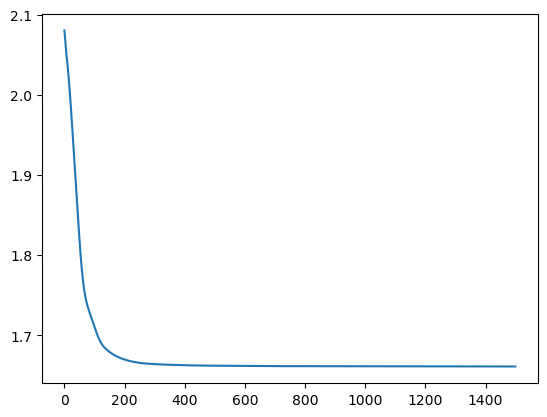

In [18]:
import torch.nn as nn

LEARNING_RATE = 0.001
EPOCHS = 1500

# Define the model
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, len(action_folders)),
    nn.Softmax(dim=1),
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(torch.tensor(x_train).float())
    loss = loss_fn(y_pred, torch.tensor(y_train).long())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss {loss.item()}")

model.eval()
y_pred = model(torch.tensor(x_train).float())
y_pred = torch.argmax(y_pred, dim=1)

# Evaluate training accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy on training set is {accuracy}")

# Plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)

[3 3 6 1 0 1 7 2 0 2 1 5 2 1 1 4 1 5 2 7 2 3 4 5 6 2 0 5 1 2 0 0 0 0 5 4 2
 6 6 3 7 4 5 1 0 0 7 0 1 7 4 5 2 0 5 0 5 0 3 3 1 1 0 2 4 0 2 5 5 0 1 5 0 1
 6 2 3 0 5 5 1 0 0 5 5 7 3 2 7 4 2 3 1 1 5 2 1 0 1 1 5 5 1 0 5 0]
Accuracy on testing set is 0.6486486486486487
              precision    recall  f1-score   support

           0       0.68      0.49      0.57        35
           1       0.51      0.89      0.65        54
           2       0.62      0.76      0.68        33
           3       0.62      0.66      0.64        32
           4       0.83      0.92      0.87        52
           5       0.00      0.00      0.00        36
           6       0.67      0.69      0.68        29
           7       0.87      0.52      0.65        25

    accuracy                           0.65       296
   macro avg       0.60      0.62      0.59       296
weighted avg       0.59      0.65      0.61       296



c:\Users\tohmi\anaconda3\envs\epfl_ML\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tohmi\anaconda3\envs\epfl_ML\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tohmi\anaconda3\envs\epfl_ML\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


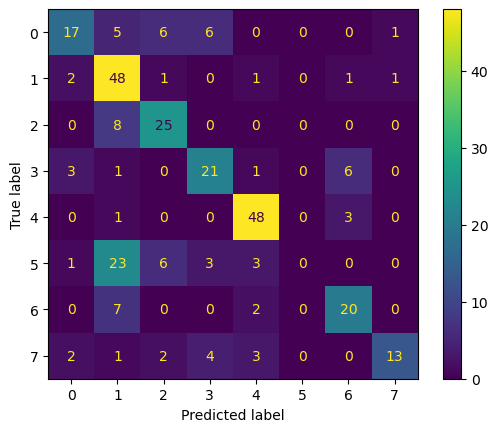

In [19]:
# Evaluate the model

model.eval()
y_pred = model(
    torch.tensor(x_test).float()
)  

# Convert matrix values to 0 if below 0.7
y_max = torch.max(y_pred, dim=1)
y_pred = torch.argmax(y_pred, dim=1)

# Get indices where y_max is less than 0.7 and see the y_test of those indices
indices = y_max.values < 0.7
print(y_test[indices])

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on testing set is {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=range(len(action_folders)))

display.plot()

In [20]:
# Save the weights

weights_str = ""
biases_str = ""

for param in model.named_parameters():
    isBias = False
    if "0.weight" in param[0]:
        weights_str += ("custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {")
        isBias = False
    if "0.bias" in param[0]:
        biases_str += ("custom_float input_bias[HIDDEN_LAYER_NODES] = {")
        isBias = True
    if "2.weight" in param[0]:
        weights_str += ("custom_float output_weight[HIDDEN_LAYER_NODES * OUTPUT_NODES] = {")
        isBias = False
    if "2.bias" in param[0]:
        biases_str += ("custom_float output_bias[OUTPUT_NODES] = {")
        isBias = True
        
    weight = param[1].detach().numpy().flatten().tolist()
    for w in weight:
        if isBias:
            biases_str += str(w) + ","
        else:
            weights_str += str(w) + ","
            
    if isBias:
        biases_str += "};\n\n"
    else:
        weights_str += "};\n\n"
        
print(weights_str)
print(biases_str)

custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {0.023168394342064857,0.006321884226053953,0.011780722998082638,-0.016009803861379623,0.0027099717408418655,0.027693036943674088,0.02908375672996044,-0.011975654400885105,0.0022462510969489813,-0.011521230451762676,-0.01469052117317915,-0.011908045969903469,0.05549155920743942,-0.0007494785240851343,0.004095066804438829,-0.02626682259142399,-0.0014253135304898024,0.01831219345331192,0.0008202562457881868,-0.010167785920202732,-0.005150770302861929,0.0016780516598373652,-0.007572272326797247,-0.026108043268322945,0.03713342919945717,-0.010265917517244816,-0.00390412169508636,-0.004381492268294096,-0.007245911750942469,-0.05011541768908501,-0.006630950141698122,-0.013186694122850895,-0.0059615508653223515,-0.005525032989680767,-0.0015057801501825452,-0.008224468678236008,0.05810844153165817,-0.017375890165567398,-0.010618059895932674,-0.008560056798160076,-0.007424741983413696,-0.07287486642599106,0.0014321885537356138,-0.0055

In [21]:
# Generate test cases for HLS

random.seed(SEED)

TEST_CASES = 100

test_cases = []

for i in range(TEST_CASES):
    test_case = random.choice(x_test)
    test_cases.append(test_case)

test_cases = np.array(test_cases)
single_test_case = test_cases[12]

raw_output = model(torch.tensor(test_cases).float()).detach().numpy()
pred_output = np.argmax(raw_output, axis=1)
single_pred_output = pred_output[12]

test_cases_str = "float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {"
pred_output_str = "int test_output[TEST_CASES_NUMBER] = {"

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ","
for output in pred_output:
    pred_output_str += str(output) + ","

test_cases_str += "};\n"
pred_output_str += "};\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {0.4297596146116648,0.2550546095450834,0.0043221984738571724,0.10614546738013164,-0.00776957579936303,0.028832063462302087,0.1962971294663523,0.03915741180692178,-0.18681296213470408,0.1539788514306444,-0.07326980471572983,-0.1633565578112393,0.5751611708141172,0.47487419000179526,-0.3597351082218786,0.26805765058002545,-0.08743434316383769,-0.10203117506522467,-0.18809078415293806,-0.10840258338526945,-0.1753402893070294,-0.02217675993803697,-0.01663209704888571,-0.19190838860600629,-0.04248209569227809,-0.054968626103612646,0.0862068353119831,-0.029576990490354713,-0.10033717605605526,-0.2964140085653171,-0.17082190020179008,-0.05218530412829409,-0.002068475566676423,0.016839242260242734,-0.18778747723427333,-0.31863520806198786,0.10718360426839256,0.06363736492795209,0.2648467689655203,-0.0511396919207606,-0.11711620592897021,-0.45432023926748866,-0.09573846183257109,-0.09387715792846513,-0.055293278901390526,-0.08625686100962084,-0

In [22]:
# Generate single test case for pynq testing

TEST_CASES = 3

test_cases = []

for i in range(TEST_CASES):
    test_case = random.choice(x_test)
    test_cases.append(test_case)
    
pred_output = model(torch.tensor(test_cases).float()).detach().numpy()

pred_output = np.argmax(pred_output, axis=1)

test_cases = np.array(test_cases)


test_cases_str = "input = ["
pred_output_str = "output = ["

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ", "
for output in pred_output:
    pred_output_str += str(output) + ", "

test_cases_str += "]\n"
pred_output_str += "]\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

input = [0.16300468173336602, 0.1001658199395428, -0.064774569020382, -0.060655811704228776, -0.8805549852263732, -1.5362654067928652, -0.2298136782423245, 0.10456912568604818, 0.1315450093786521, -0.00535672309478041, -0.8750965912270898, -1.1953260576205382, 0.019351842469364704, 0.3459716758738643, 0.07741672509307493, -0.015383163930422933, -1.7780341113922875, -3.2763050054428144, -0.21088615873229202, 0.0359589842434076, 0.2143802057459745, -0.005794567553713194, 0.02897645799165306, -0.06201824863193403, -0.41664893634713646, -0.058483369710519914, -0.17584181790318903, -0.09410869676435296, 0.9271308281541506, 1.6801739676118188, -0.22121706880177994, -0.10217235529304965, 0.14336068776342883, -0.3061501156386568, -0.2712710882137058, -0.204162867179211, -0.5324753272301607, -0.07526085626948976, -0.281778863396251, -0.1367432698932771, 1.4671242810086937, 2.9309142542906264, -0.1487955141367506, -0.09916466711764421, -0.17905017671104284, -0.09058355046686685, 0.11592910243230